# Observations:
In this assignment, we explored the vulnerability of convolutional neural networks to white-box adversarial attacks and experimented with adversarial training as a defense strategy, using the CIFAR-10 dataset.(part 1)

Our model initially performed very well:

**Clean test accuracy: ~93%**

**Adversarial test accuracy (ε = 1.0): ~63%**

This indicated that even without explicit adversarial defenses, the model was somewhat resilient — likely due to factors like batch normalization and strong data augmentation. However, adversarial inputs still caused a significant drop in performance, despite appearing nearly identical to clean images.

To improve robustness, we implemented adversarial training by generating perturbed inputs on-the-fly during training using normalized gradient methods. After retraining:(part2)

**Clean accuracy decreased to ~69.6%**

**Adversarial accuracy dropped to ~34.9%**

Interestingly, adversarial accuracy was lower than before, which suggests that while the model learned to resist a specific type of attack during training, it may have overfitted to that pattern and generalized less effectively to other adversarial variations. This outcome highlights that adversarial training, while helpful, is not a one-size-fits-all solution and requires careful tuning of attack method, strength (ε), and integration into the training process.

In [ ]:
from time import perf_counter

import torch
import numpy as np
from matplotlib import pyplot as plt

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms.v2 import ToTensor, RandomCrop, RandomHorizontalFlip, Compose, CenterCrop, RandomAffine, ColorJitter

In [ ]:
train_transforms = [ToTensor()]
test_transforms = [ToTensor()]

flip = True
rotation = 15
scale = (0.8, 1.2)
color = (0.95, 1.05)
crop = 30

if color is not None:
    train_transforms.append(ColorJitter(color, color, color, (color[0]-1, color[1]-1)))  # brightness, contrast, saturation, hue
if rotation > 0 or scale is not None:
    train_transforms.append(RandomAffine(rotation, scale=scale))
if flip:
    train_transforms.append(RandomHorizontalFlip())
if crop < 32:
    train_transforms.append(RandomCrop(crop))
    test_transforms.append(CenterCrop(crop))

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=Compose(train_transforms))

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=Compose(test_transforms))

100%|██████████| 170M/170M [00:06<00:00, 25.4MB/s]


In [ ]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True,
                              num_workers=32)
test_dataloader = DataLoader(test_data, batch_size=batch_size,
                             num_workers=32)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Shape of X [N, C, H, W]: torch.Size([128, 3, 30, 30])
Shape of y: torch.Size([128]) torch.int64


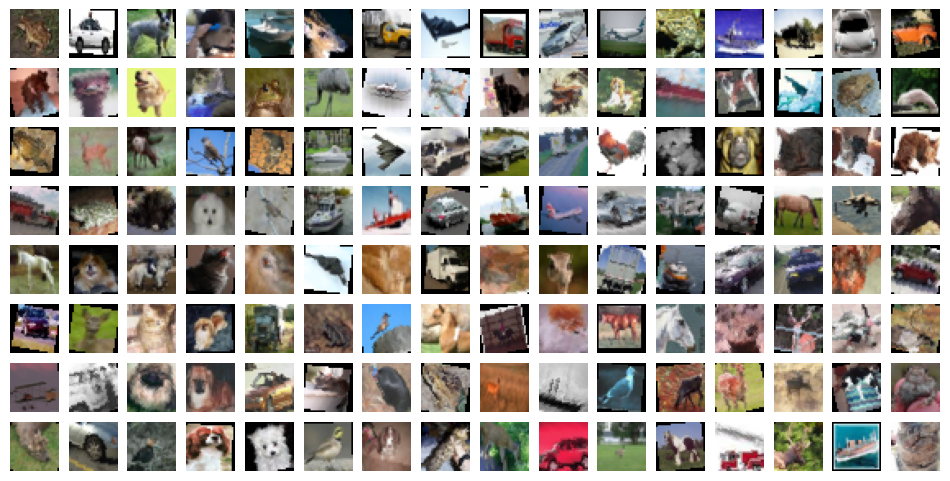

In [ ]:
# look at some of the augmented images
for X, _ in train_dataloader:
    plt.figure(figsize=(12, 6))
    for ind, img in enumerate(X):
        plt.subplot(8, 16, ind+1)
        plt.imshow(img.permute((1, 2, 0)))
        plt.axis("off")
    plt.show()
    break

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


def conv_layer(previous_filters, current_filters, kernel_size):
    return nn.Sequential(nn.Conv2d(previous_filters, current_filters, kernel_size, padding="same"),
                         nn.BatchNorm2d(current_filters),
                         nn.Mish())


def vgg_level(n_layers, prev_filters, current_filters, kernel_size):
    level = nn.Sequential()
    for layer_ind in range(n_layers):
        level.append(conv_layer(prev_filters if layer_ind == 0 else current_filters, current_filters, kernel_size))
    level.append(nn.MaxPool2d(2, ceil_mode=True))
    return level


def vgg_body(n_levels, layers_per_level, start_filters, kernel_size, input_channels=3, filter_multiplier=2):
    body = nn.Sequential()
    current_filters = start_filters
    previous_filters = input_channels

    for level_ind in range(n_levels):
        body.append(vgg_level(layers_per_level, previous_filters, current_filters, kernel_size))
        previous_filters = current_filters
        current_filters *= 2
    return body


def hidden_linear(dim):
    layer = nn.Sequential(nn.LazyLinear(dim),
                          nn.BatchNorm1d(dim),
                          nn.Mish())
    return layer


n_levels = 4
layers_per_level = 3
start_filters = 64
kernel_size = 3
linear_dim = 1024

model = nn.Sequential()
model.append(vgg_body(n_levels, layers_per_level, start_filters, kernel_size))
model.append(nn.Flatten())
model.append(hidden_linear(linear_dim))
model.append(nn.Linear(linear_dim, 10))

# for reference: this is what a "flat" model construction could look like
# rather than using nested functions
#prev_filters = 3
#current_filters = start_filters
#for level_ind in range(n_levels):
    #for layer_ind in range(layers_per_level):
    #    model.append(conv_layer(prev_filters, current_filters, kernel_size))
        #model.append(nn.Conv2d(prev_filters, current_filters, kernel_size, padding="same"))
        #model.append(nn.BatchNorm2d(current_filters))
        #model.append(nn.Mish())
    #    prev_filters = current_filters
    #model.append(vgg_level(layers_per_level, prev_filters, current_filters, kernel_size))

    #model.append(nn.MaxPool2d(2, ceil_mode=True))
    #prev_filters = current_filters
    #current_filters *= 2

#model.append(nn.Flatten())
#model.append(nn.LazyLinear(linear_dim))
#model.append(nn.BatchNorm1d(linear_dim))
#model.append(nn.GELU())

model = model.to(device)
with torch.no_grad():
    model(next(iter(train_dataloader))[0].to(device))
print(model)


def glorot_init(layer: nn.Module):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)
        nn.init.zeros_(layer.bias)


#with torch.no_grad():
#    model.apply(glorot_init)


def accuracy(labels: torch.tensor,
             outputs: torch.tensor) -> torch.tensor:
    predictions = torch.argmax(outputs, axis=-1)
    matches = labels == predictions
    return matches.float().mean()

Using cuda device
Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Mish()
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

In [ ]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3)

In [ ]:
class EarlyStopping:
    def __init__(self, model, patience, direction="min", min_delta=0.0001, verbose=False):
        if direction not in ["min", "max"]:
            raise ValueError("direction should be 'min' or 'max', you passed {}".format(direction))
        self.best_state_dict = {key: None for key in model.state_dict()}
        self.best_value = np.inf if direction == "min" else -np.inf
        self.direction = direction
        self.min_delta = min_delta
        self.model = model

        self.patience = patience
        self.disappointment = 0
        self.verbose = verbose

    def update(self, value):
        if ((self.direction == "min" and value < self.best_value - self.min_delta)
            or (self.direction == "max" and value > self.best_value + self.min_delta)):
            self.best_value = value
            for key in model.state_dict():
                self.best_state_dict[key] = model.state_dict()[key].clone()
            self.disappointment = 0
            if self.verbose:
                print("New best value found; no longer disappointed")
            return 0
        else:
            self.disappointment += 1
            if self.verbose:
                print("EarlyStopping disappointment increased to {}".format(self.disappointment))

            if self.disappointment > self.patience:
                if self.verbose:
                    print("EarlyStopping has become too disappointed; now would be a good time to cancel training")
                    print("Restoring best model from state_dict")
                self.model.load_state_dict(self.best_state_dict)
                return 1
            else:
                return 0

In [ ]:
def train_model(model: nn.Module,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler.LRScheduler,
                training_loader: DataLoader,
                validation_loader: DataLoader,
                n_epochs: int,
                verbose: bool = True):
    n_training_examples = len(training_loader.dataset)
    batches_per_epoch = n_training_examples // training_loader.batch_size
    print("Running {} epochs at {} steps per epoch.".format(n_epochs, batches_per_epoch))

    # note, for training we only track the average over the epoch.
    # this is somewhat imprecise, as the model changes over the epoch.
    # so the metrics at the end of the epoch will usually be better than at the start,
    # but we average over everything.
    # we could record train metrics more often to get a better picture of training progress.
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    early_stopper = EarlyStopping(model, patience=9, verbose=verbose)

    for epoch in range(n_epochs):
        if verbose:
            print("Starting epoch {}...".format(epoch + 1), end=" ")

        start_time = perf_counter()
        epoch_train_losses = []
        epoch_train_accuracies = []

        model.train()
        for batch_ind, (input_batch, label_batch) in enumerate(training_loader):
            batch_loss, batch_accuracy = train_step(input_batch, label_batch, model, loss_fn, optimizer)
            epoch_train_losses.append(batch_loss.item())
            epoch_train_accuracies.append(batch_accuracy.item())

        end_time = perf_counter()
        time_taken = end_time - start_time

        # evaluate after each epoch
        val_loss, val_accuracy = evaluate(model, validation_loader, loss_fn)
        scheduler.step(val_loss)

        should_stop = early_stopper.update(val_loss)

        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy.item())
        train_losses.append(np.mean(epoch_train_losses))
        train_accuracies.append(np.mean(epoch_train_accuracies))

        if verbose:
            print("Time taken: {} seconds".format(time_taken))
            print("\tTrain/val loss: {} / {}".format(train_losses[-1], val_losses[-1]))
            print("\tTrain/val accuracy: {} / {}".format(train_accuracies[-1], val_accuracies[-1]))
            print("\tLR is now {}".format(scheduler.get_last_lr()[0]))

        if should_stop:
            print("Early stopping...")
            break

    return {"train_loss": np.array(train_losses), "train_accuracy": np.array(train_accuracies),
            "val_loss": np.array(val_losses), "val_accuracy": np.array(val_accuracies)}


def train_step(input_batch, label_batch, model, loss_fn, optimizer):
    input_batch = input_batch.to(device)
    label_batch = label_batch.to(device)
    output_batch = model(input_batch)
    batch_loss = loss_fn(output_batch, label_batch)

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    with torch.no_grad():
        batch_accuracy = accuracy(label_batch, output_batch)
    return batch_loss, batch_accuracy


def evaluate(model, dataloader, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for input_batch, label_batch in dataloader:
            input_batch = input_batch.to(device)
            label_batch = label_batch.to(device)
            predictions = model(input_batch)
            val_loss += loss_fn(predictions, label_batch)
            correct += (predictions.argmax(axis=1) == label_batch).type(torch.float).sum()

        val_loss /= num_batches
        val_accuracy = correct / size
    return val_loss, val_accuracy

In [ ]:
# uncomment if you want to train yourself
#metrics = train_model(model, loss_fn, optimizer, scheduler, train_dataloader, test_dataloader,
#                      n_epochs=200)

In [ ]:
#uncomment if you want to load the checkpoint instead
model.load_state_dict(torch.load("/content/04_cifar_model.pt", weights_only=True))

<All keys matched successfully>

In [ ]:
# Regular evaluation
val_loss, val_acc = evaluate(model, test_dataloader, loss_fn)
print(f"Test Accuracy on clean data: {val_acc:.4f}, Loss: {val_loss:.4f}")

# Start adversarial evaluation
import torch.nn.functional as F

model.eval()
correct = 0
total = 0
epsilon = 1.0

for input_batch, label_batch in test_dataloader:
    input_batch = input_batch.to(device)
    label_batch = label_batch.to(device)

    input_batch.requires_grad = True

    output = model(input_batch)
    loss = F.cross_entropy(output, label_batch)

    model.zero_grad()
    loss.backward()

    grad = input_batch.grad

    # Normalize the gradient
    grad_norm = grad.view(grad.shape[0], -1).norm(p=2, dim=1).view(-1, 1, 1, 1)
    grad_normalized = grad / (grad_norm + 1e-8)

    adv_images = input_batch + epsilon * grad_normalized
    adv_images = torch.clamp(adv_images, 0, 1)

    # Evaluate model on adversarial images
    with torch.no_grad():
        adv_output = model(adv_images)
        preds = adv_output.argmax(dim=1)
        correct += (preds == label_batch).sum().item()
        total += label_batch.size(0)

# Final adversarial accuracy
adv_acc = correct / total
print(f"Test Accuracy on adversarial data (ε={epsilon}): {adv_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy on clean data: 0.9349, Loss: 0.4642
Test Accuracy on adversarial data (ε=1.0): 0.6067


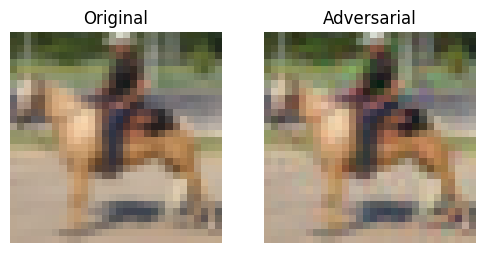

In [ ]:
# Visualize 1 clean vs adversarial image
import matplotlib.pyplot as plt

orig_img = input_batch[0].detach().cpu().permute(1, 2, 0)
adv_img = adv_images[0].detach().cpu().permute(1, 2, 0)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(adv_img)
plt.title("Adversarial")
plt.axis("off")
plt.show()


In [ ]:
# only run this if you trained yourself, duh
plt.plot(metrics["train_loss"], label="train")
plt.plot(metrics["val_loss"], label="validation")
plt.legend()
plt.title("Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(metrics["train_accuracy"], label="train")
plt.plot(metrics["val_accuracy"], label="validation")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.show()

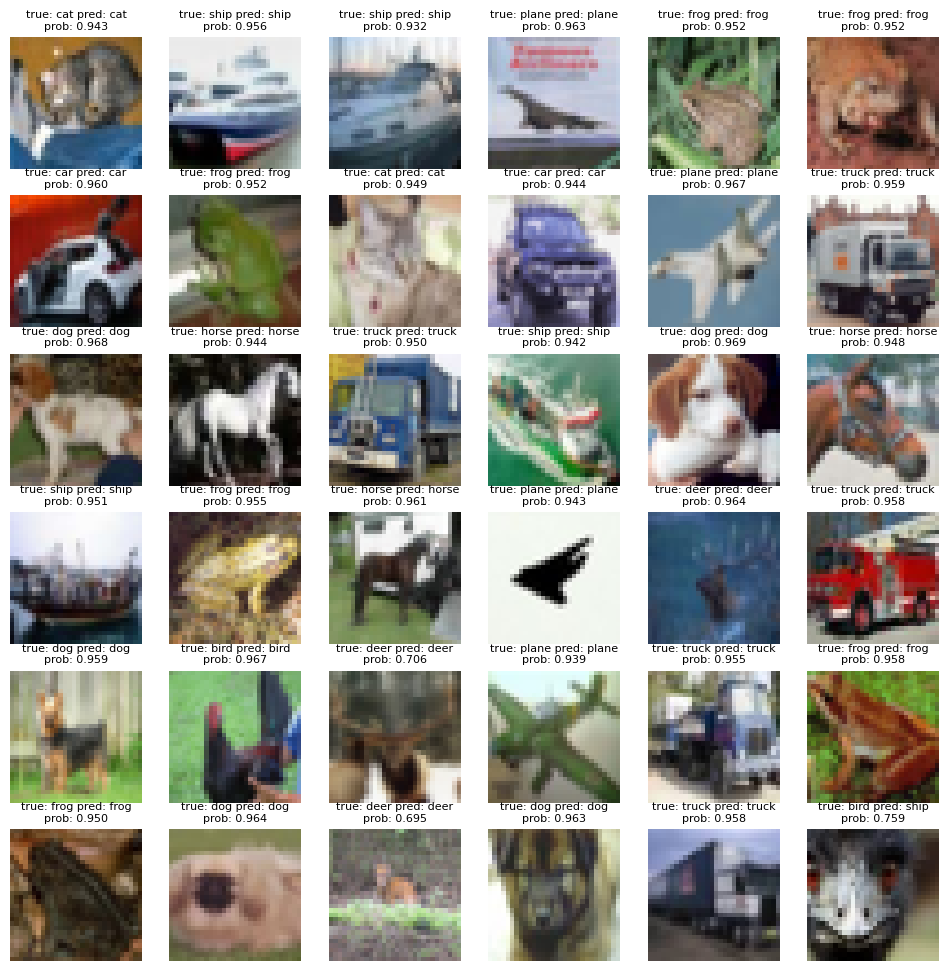

In [ ]:
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

for X, y in test_dataloader:
    with torch.no_grad():
        probabilities = torch.nn.functional.softmax(model(X.to(device)), dim=1)
        predictions = probabilities.argmax(axis=1)

    plt.figure(figsize=(12, 12))
    for ind, img in enumerate(X[:36]):
        pred_here = predictions[ind]
        prob_here = probabilities[ind, pred_here].item()
        true_here = y[ind]

        plt.subplot(6, 6, ind+1)
        plt.imshow(img.permute((1, 2, 0)))
        plt.axis("off")

        plt.title("true: {} pred: {}\nprob: {:.3f}".format(classes[true_here], classes[pred_here], prob_here),
                  fontsize=8)
    plt.show()
    break

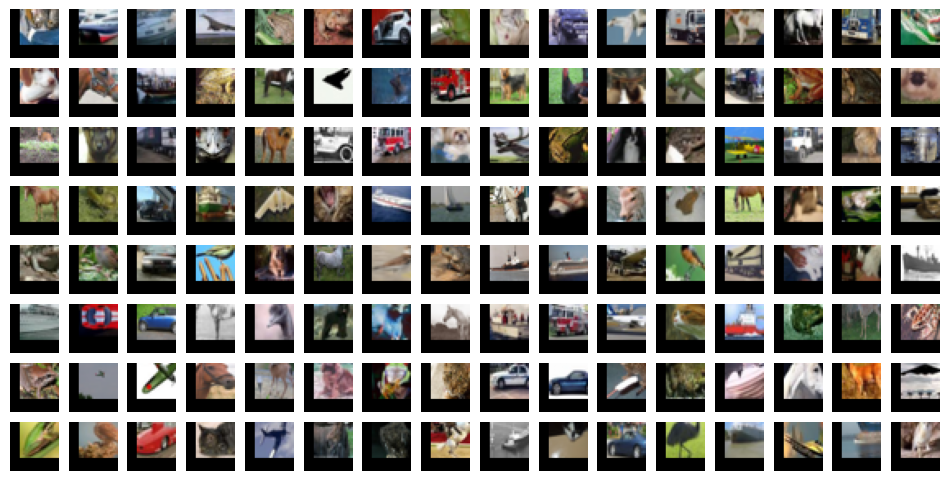

In [ ]:
from torchvision.transforms.v2.functional import affine


# showcase of the affine transform: Useful if you want to do option 1 of the assignment
translate_x = 6
translate_y = -8
for X, _ in test_dataloader:
    X = affine(X, angle=0, scale=1, shear=0., translate=[translate_x, translate_y])
    plt.figure(figsize=(12, 6))
    for ind, img in enumerate(X):
        plt.subplot(8, 16, ind+1)
        plt.imshow(img.permute((1, 2, 0)))
        plt.axis("off")
    plt.show()
    break

In [ ]:
# showcase of how one might iterate over several submodules and apply them one-by-one.
# useful for option 2.
# of course you want to find a more programmatic way of doing this, e.g. with loops


conv_body = model[0]
dummy_inp = torch.zeros(1, 3, crop, crop).to(device)
features = dummy_inp

features = conv_body[0][0](features)
#plot(features)
features = conv_body[0][1](features)
#plot(features)
# ...
features = conv_body[1][0](features)
#plot(features)
# etc.
